In [1]:
import sys, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List, Tuple, Callable, Any, Dict

from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.midstep_composites import midstep_composition_transformation_correction
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.free_energy import calculate_midstep_triads, midstep_excess_vals

from methods.PolyCG import polycg
from methods.PolyCG.polycg.SO3 import so3
from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3, rotmat2euler_so3
from methods.PolyCG.polycg.transforms.transform_SE3 import euler2rotmat_se3, rotmat2euler_se3

# from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params
# from methods.PolyCG.polycg.transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans


# Load the autoreload extension
%load_ext autoreload

# Set autoreload to reload all modules before executing code
%autoreload 2

np.set_printoptions(linewidth=250, precision=4, suppress=True)

### Load Unrestrained data

In [30]:
# MD sampled
basefn = 'MDParams/free_fitted'
free_gs    = np.load(basefn + '_gs.npy')
free_stiff = np.load(basefn + '_stiff.npy')
seq        = polycg.load_sequence(basefn+'_seq')
free_gs = free_gs.reshape((len(free_gs)//6,6))
# print(seq)
print(free_gs.shape)
print(free_stiff.shape)

# cgNA+
basefn = 'MDParams/nucseq_cgf_params'
free_cgnap_gs    = np.load(basefn + '_gs.npy')
# free_stiff = np.load(basefn + '_stiff.npy')
free_cgnap_stiff = sp.sparse.load_npz(basefn + '_stiff.npz').toarray()
# free_seq   = polycg.load_sequence(basefn+'_seq')
print(free_cgnap_gs.shape)
print(free_cgnap_stiff.shape)

# free_stiff  = free_cgnap_stiff
# free_gs     = free_cgnap_gs

(146, 6)
(876, 876)
(146, 6)
(876, 876)


### Sample midstep configurations

In [31]:
Nsnap = 100000

covmat = np.linalg.inv(free_stiff)
Xd = np.random.multivariate_normal(np.zeros(len(covmat)), covmat,Nsnap)
Xd = Xd.reshape((len(Xd),len(Xd[0])//6,6))

X = free_gs + Xd
print(Xd.shape)

taus = np.zeros((len(Xd),len(Xd[0])+1,4,4))
taus[:,0] = np.eye(4)
for s in range(len(X)):
    for i in range(len(X[0])):
        g = so3.se3_euler2rotmat(X[s,i])
        taus[s,i+1] = taus[s,i] @ g

(100000, 146, 6)


### Calculate Midstep Triads

In [32]:
def calculate_midstep_triads(
    triad_ids,  # index of the lower (left-hand) triad neighboring the constraint midstep-triad
    nucleosome_triads: np.ndarray
) -> np.ndarray:
    midstep_triads = np.zeros((len(triad_ids),4,4))
    for i,id in enumerate(triad_ids):
        T1 = nucleosome_triads[id]
        T2 = nucleosome_triads[id+1]
        midstep_triads[i,:3,:3] = T1[:3,:3] @ so3.euler2rotmat(0.5*so3.rotmat2euler(T1[:3,:3].T @ T2[:3,:3]))
        midstep_triads[i,:3,3]  = 0.5* (T1[:3,3]+T2[:3,3])
        midstep_triads[i,3,3]   = 1
    return midstep_triads

In [33]:
midstep_ids = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]
ms_triads = np.empty((len(taus),len(midstep_ids),4,4))
for i,snap in enumerate(taus):
    ms_triads[i] = calculate_midstep_triads(midstep_ids,taus[i])
    
print(ms_triads.shape)

(100000, 28, 4, 4)


In [34]:
params = np.empty((len(ms_triads),len(midstep_ids)-1,6))
for s in range(len(ms_triads)):
    for i in range(len(midstep_ids)-1):
        tau1 = ms_triads[s,i]
        tau2 = ms_triads[s,i+1]
        g = so3.se3_triads2euler(tau1,tau2)
        params[s,i] = g

### Fix Values

In [35]:
fparams = np.copy(params)
for i in range(len(fparams[0])):
    shifted = False
    for s in range(1,len(fparams)):
        Om1 = fparams[s-1,i,:3]
        Om2 = fparams[s,i,:3]
        nOm2 = np.linalg.norm(Om2)
        uOm2 = Om2/nOm2
        shift = np.round (1./(2*np.pi) * (np.dot(Om1,uOm2) - nOm2))
        if np.abs(shift) > 0:
            shifted = True
            nOm2p = nOm2 + shift * 2*np.pi
            Om2p = nOm2p * uOm2
            fparams[s,i,:3] = Om2p
    if shifted:
        print(f'shifted {i}')
                
        
# maxdiff = 0.5   
# removeids = []
# for i in range(len(fparams[0])):
#     for s in range(1,len(fparams)-1):
#         Om1 = fparams[s-1,i,:3]
#         Om2 = fparams[s,i,:3]
#         Om3 = fparams[s+1,i,:3]
        
#         if np.linalg.norm(Om2-Om1) > maxdiff and np.linalg.norm(Om2-Om3) > maxdiff:
#             removeids.append(s)  
# removeids = sorted(list(set(removeids)))
# print(f'num removed = {len(removeids)}')
# fparams = np.delete(fparams, removeids,axis=0) 

shifted 4
shifted 5
shifted 9
shifted 11
shifted 15
shifted 17
shifted 21
shifted 22


### Plot mistep params

step = 0


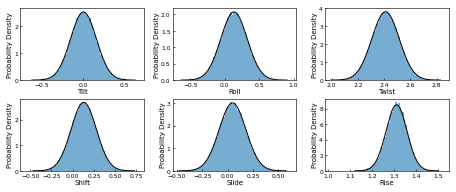

step = 1


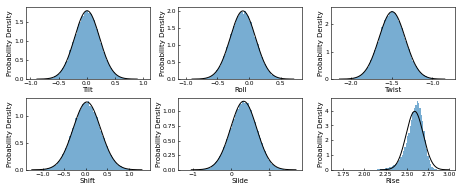

step = 2


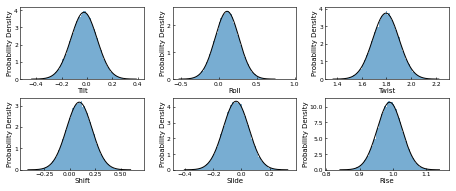

step = 3


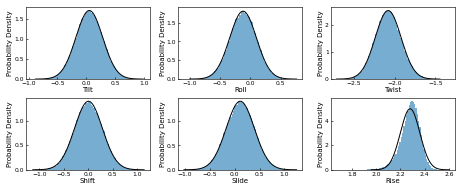

step = 4


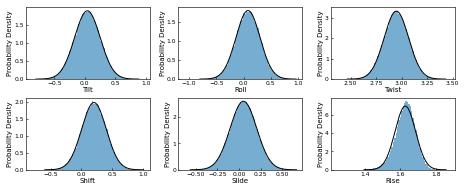

step = 5


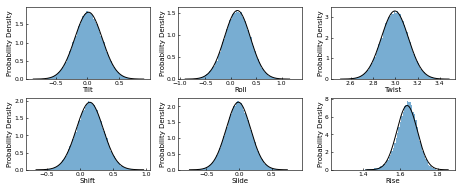

step = 6


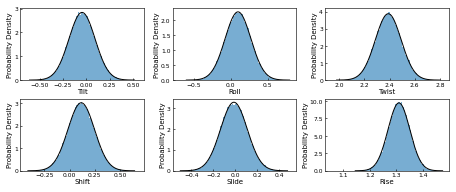

step = 7


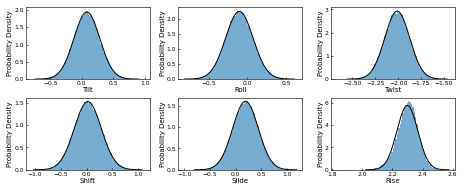

step = 8


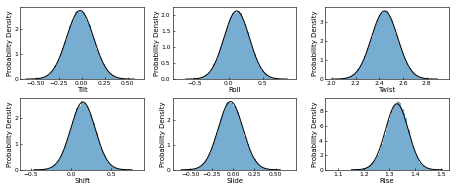

step = 9


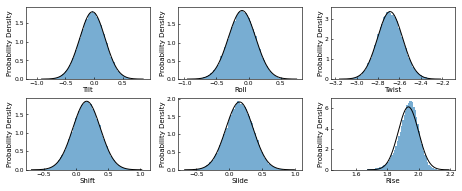

step = 10


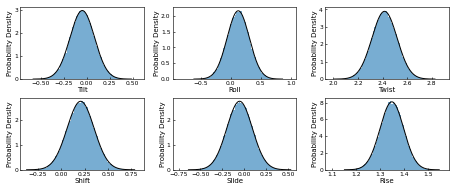

step = 11


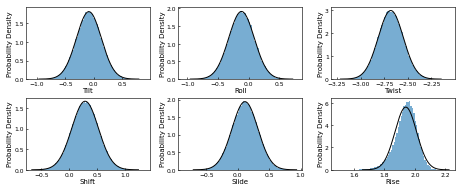

step = 12


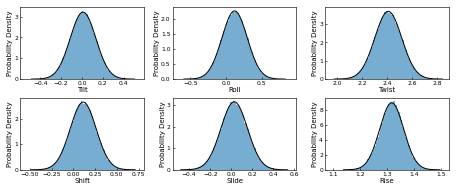

step = 13


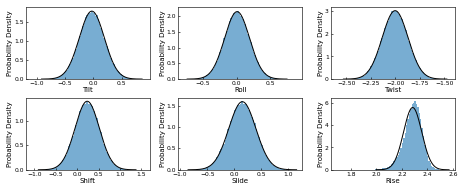

step = 14


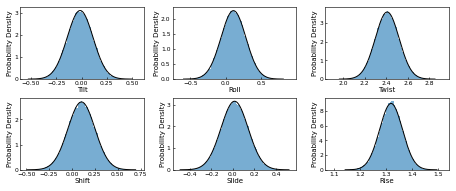

step = 15


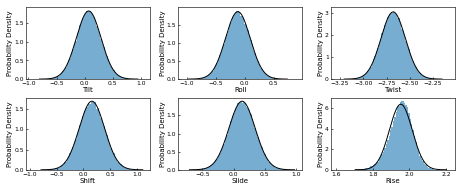

step = 16


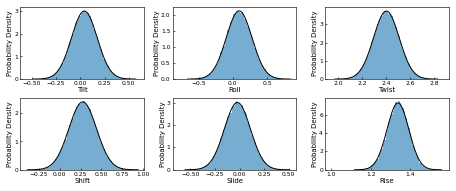

step = 17


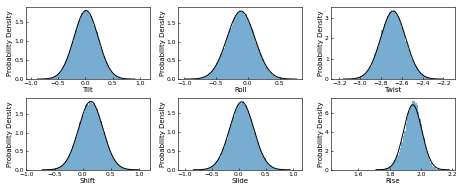

step = 18


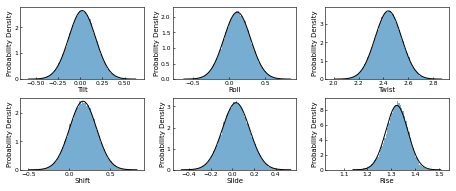

step = 19


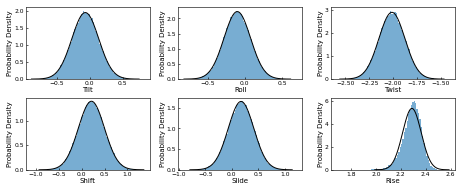

step = 20


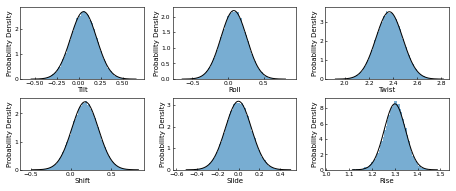

step = 21


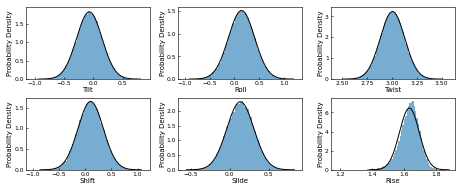

step = 22


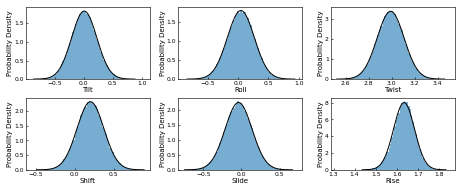

step = 23


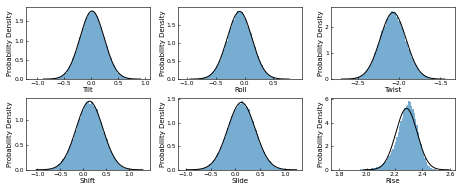

step = 24


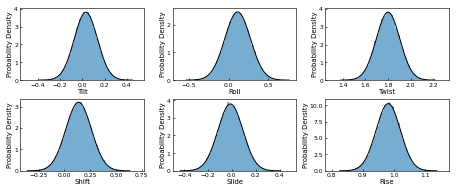

step = 25


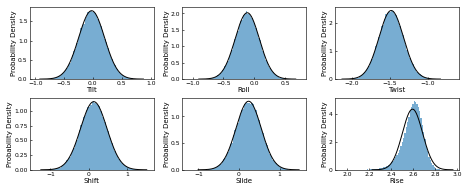

step = 26


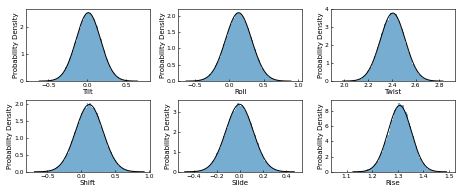

In [36]:
# fparams = params

labels = ['Tilt','Roll','Twist','Shift','Slide','Rise']

bins = 80

tick_pad            = 2
axlinewidth         = 0.9
axtick_major_width  = 0.6
axtick_major_length = 1.6
tick_labelsize      = 6
label_fontsize      = 7

for step in range(len(params[0])):
    print(f'step = {step}')
    fig = plt.figure(figsize=(17./2.54,7./2.54))
    ax = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    axes = [ax,ax2,ax3,ax4,ax5,ax6]
    
    for i,ax in enumerate(axes):
        vals = fparams[:,step,i]
        ax.hist(vals,bins=bins,density=True,alpha=0.6)
        
        # vals = params[:,step,i]
        # ax.hist(vals,bins=bins,density=True,alpha=0.6)
        
        
        mu = np.mean(vals)
        var = np.var(vals)
        std = np.sqrt(var)
        rnge = std*4
        xvals = np.linspace(mu-rnge,mu+rnge,500)
        norm = sp.stats.norm.pdf(xvals,mu,std) 
        ax.plot(xvals,norm,c='black',lw=1.0)
        
        ax.tick_params(axis="both",which='major',direction="in",width=axtick_major_width,length=axtick_major_length,labelsize=tick_labelsize,pad=tick_pad)
        ax.set_xlabel(labels[i],size = label_fontsize,labelpad=1)
        ax.set_ylabel('Probability Density',size = label_fontsize,labelpad=1)
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.7)

 
    plt.subplots_adjust(left=0.09,
                    right=0.98,
                    bottom=0.08,
                    top=0.90,
                    wspace=0.23,
                    hspace=0.26)

    plt.show()

step = 0


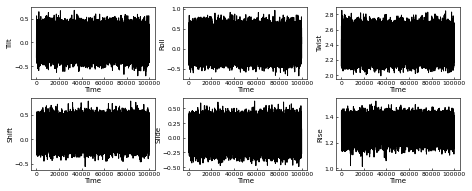

step = 1


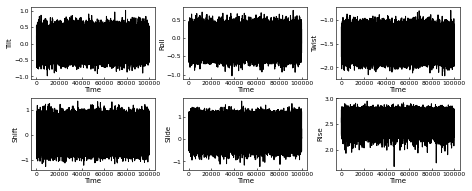

step = 2


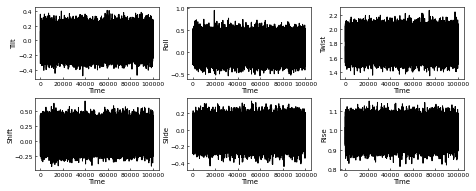

step = 3


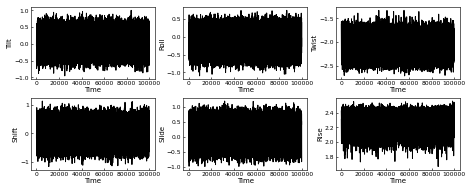

step = 4


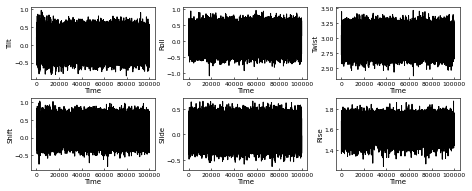

step = 5


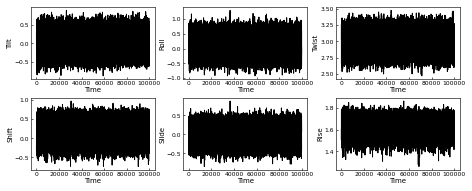

step = 6


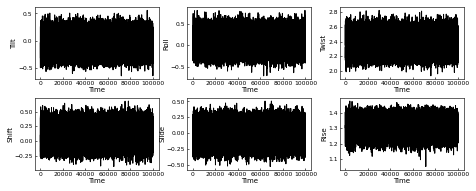

step = 7


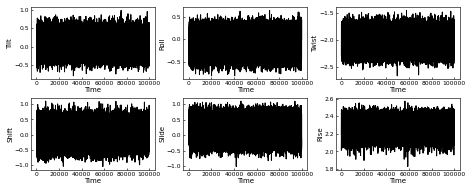

step = 8


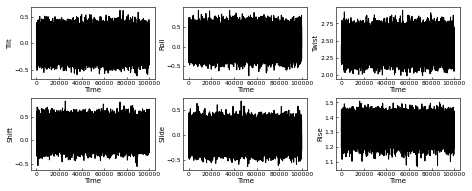

step = 9


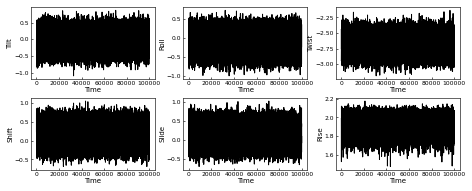

step = 10


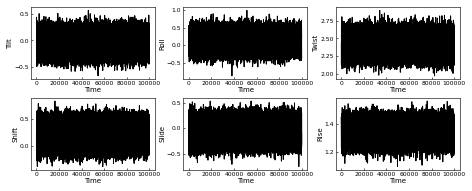

step = 11


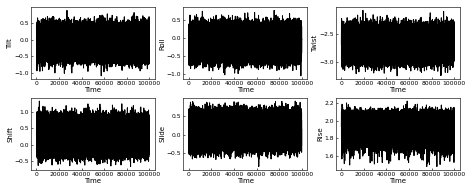

step = 12


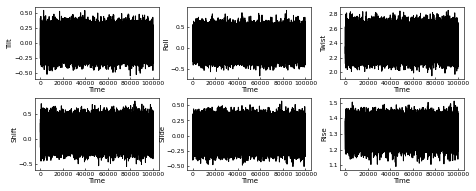

step = 13


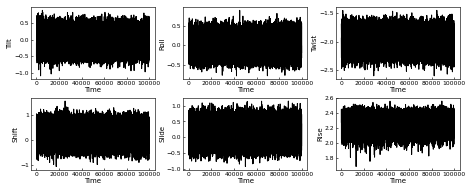

step = 14


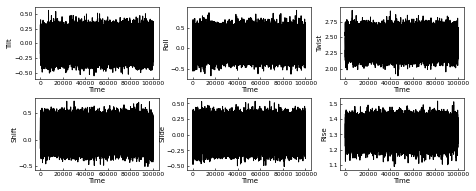

step = 15


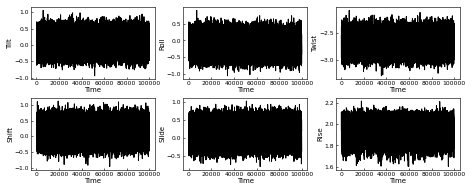

step = 16


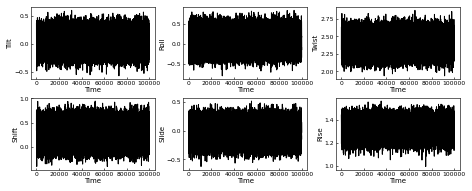

step = 17


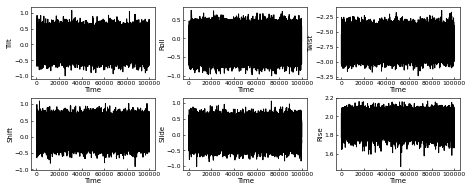

step = 18


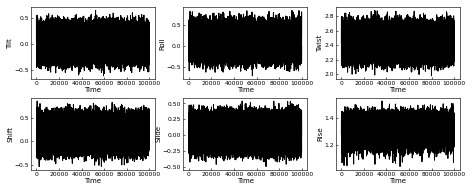

step = 19


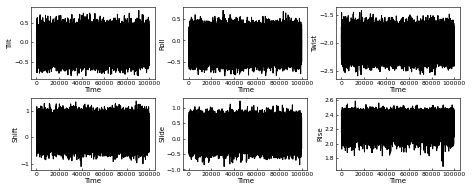

step = 20


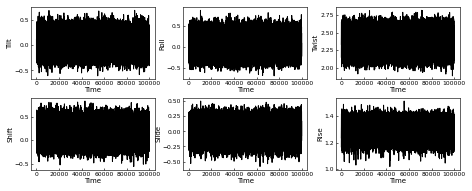

step = 21


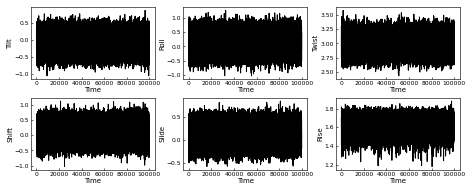

step = 22


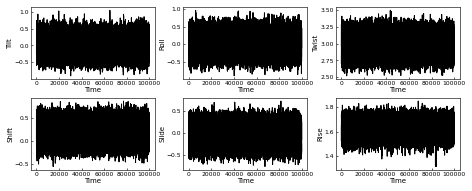

step = 23


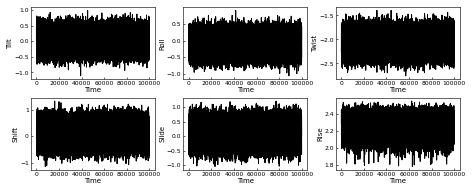

step = 24


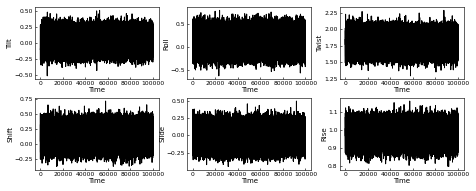

step = 25


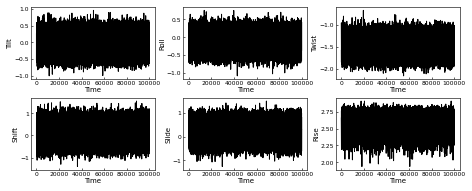

step = 26


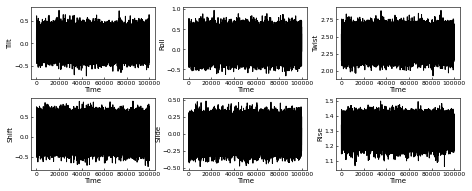

In [37]:
labels = ['Tilt','Roll','Twist','Shift','Slide','Rise']

tick_pad            = 2
axlinewidth         = 0.9
axtick_major_width  = 0.6
axtick_major_length = 1.6
tick_labelsize      = 6
label_fontsize      = 7

for step in range(len(params[0])):
    print(f'step = {step}')
    fig = plt.figure(figsize=(17./2.54,7./2.54))
    ax = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    axes = [ax,ax2,ax3,ax4,ax5,ax6]
    
    for i,ax in enumerate(axes):
        vals = fparams[:,step,i]
        ax.plot(np.arange(len(vals)),vals,c='black',lw=1.0)
        
        ax.tick_params(axis="both",which='major',direction="in",width=axtick_major_width,length=axtick_major_length,labelsize=tick_labelsize,pad=tick_pad)
        ax.set_ylabel(labels[i],size = label_fontsize,labelpad=1)
        ax.set_xlabel('Time',size = label_fontsize,labelpad=1)
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.7)
            
            
    plt.subplots_adjust(left=0.09,
                    right=0.98,
                    bottom=0.08,
                    top=0.90,
                    wspace=0.23,
                    hspace=0.26)
            
    plt.show()


### Data Analysis

In [38]:
rot_only = False

if rot_only:
    dims = 3
    flparams = np.empty((len(fparams),len(fparams[0])*3))
    for s in range(len(fparams)):
        flparams[s] = fparams[s,:,:3].flatten()
else: 
    dims = 6
    flparams = np.empty((len(fparams),len(fparams[0])*len(fparams[0,0])))
    for s in range(len(fparams)):
        flparams[s] = fparams[s].flatten()

### Mean and Covariance

In [39]:
means = np.mean(flparams,axis=0)
cov = np.cov(flparams.T)
stiff = np.linalg.inv(cov)

# manuel fix for 4th and 22nd step
v4 = means[4*6:4*6+3]
nv4 = np.linalg.norm(v4) 
uv4 = v4/nv4
v4 = (-2*np.pi + nv4) * uv4
means[4*6:4*6+3] = v4

v22 = means[22*6:22*6+3]
nv22 = np.linalg.norm(v22) 
uv22 = v22/nv22
v22 = (-2*np.pi + nv22) * uv22
means[22*6:22*6+3] = v22

basename = 'MDParams/free_midstep_sampled'
np.save(basename+'_stiff',stiff)
np.save(basename+'_gs',means)


### Plot Covariance Matrix

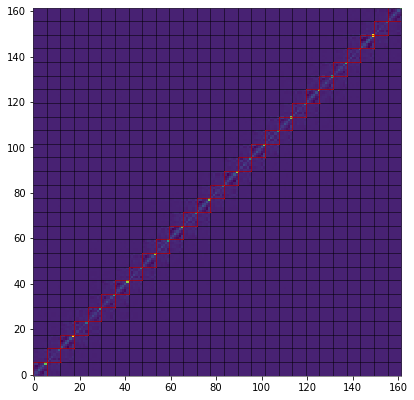

In [40]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(17./2.54,17.2/2.54))
ax = fig.add_subplot(111)
# Bilinear interpolation - this will look blurry
ax.imshow(stiff, interpolation='none', cmap='viridis')
# ax.imshow(cov, interpolation='none', cmap='viridis')

# plot blocks
for l in range(1,len(stiff)//dims+1):
    ax.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(stiff)-0.5],color='black',lw=0.5)
    ax.plot([0-0.5,len(stiff)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
    
ax.set_xlim((-0.5,len(stiff)-.5))
ax.set_ylim((-0.5,len(stiff)-.5))

# ax.set_xlim((-0.5,12-.5))
# ax.set_ylim((-0.5,12-.5))

plt.show()

# Subtract Stiffness

### Load Nuc data

In [69]:
basefn = 'MDParams/nuc_midstep_fitted'
nucstiff = np.load(basefn+'_stiff.npy')
nucgs    = np.load(basefn+'_gs.npy')

basefn = 'MDParams/nuc_midstep_individual_fitted'
nucind_stiff = np.load(basefn+'_stiff.npy')
nucind_gs    = np.load(basefn+'_gs.npy')


### Plot Both

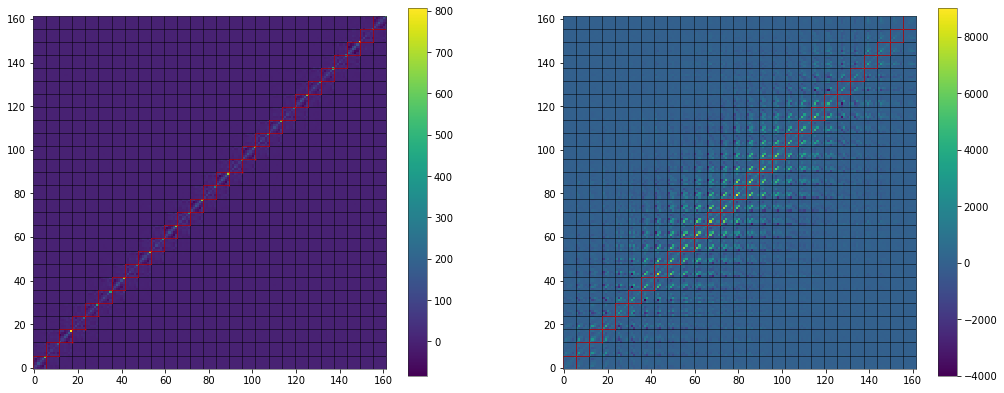

In [57]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(17./2.54*2.6,17.2/2.54))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax = ax1
mat = stiff
# Bilinear interpolation - this will look blurry
img = ax.imshow(mat, interpolation='none', cmap='viridis')
# ax.imshow(cov, interpolation='none', cmap='viridis')

# plot blocks
for l in range(1,len(mat)//dims+1):
    ax.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(mat)-0.5],color='black',lw=0.5)
    ax.plot([0-0.5,len(mat)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
ax.set_xlim((-0.5,len(mat)-.5))
ax.set_ylim((-0.5,len(mat)-.5))
fig.colorbar(img, ax=ax)


ax = ax2
mat = nucstiff
# Bilinear interpolation - this will look blurry
img = ax.imshow(mat, interpolation='none', cmap='viridis')
# ax.imshow(cov, interpolation='none', cmap='viridis')

# plot blocks
for l in range(1,len(mat)//dims+1):
    ax.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(mat)-0.5],color='black',lw=0.5)
    ax.plot([0-0.5,len(mat)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
ax.set_xlim((-0.5,len(mat)-.5))
ax.set_ylim((-0.5,len(mat)-.5))
fig.colorbar(img, ax=ax)

# ax.set_xlim((-0.5,12-.5))
# ax.set_ylim((-0.5,12-.5))

plt.show()

### Difference

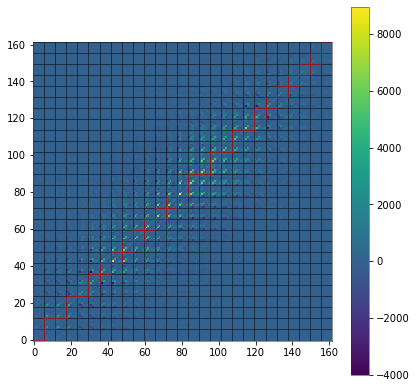

In [46]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(17./2.54,17.2/2.54))
ax1 = fig.add_subplot(111)

ax = ax1
mat = nucstiff - stiff
# Bilinear interpolation - this will look blurry
img = ax.imshow(mat, interpolation='none', cmap='viridis')
# ax.imshow(cov, interpolation='none', cmap='viridis')

# plot blocks
for l in range(1,len(mat)//dims+1):
    ax.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(mat)-0.5],color='black',lw=0.5)
    ax.plot([0-0.5,len(mat)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
ax.set_xlim((-0.5,len(mat)-.5))
ax.set_ylim((-0.5,len(mat)-.5))

fig.colorbar(img, ax=ax1)

plt.show()

In [73]:
id  = 10
id1 = id*6
id2 = (id+1)*6

diff = nucstiff - stiff
# print(diff[id1:id2,id1:id2])
print(nucstiff[id1:id2,id1:id2])
print('#####################')
print(nucind_stiff[id])
print('---------------------')
print(stiff[id1:id2,id1:id2])

# print(free_stiff[id1:id2,id1:id2]*0.34)

# print(np.linalg.inv(np.linalg.inv(nucstiff)[id1:id2,id1:id2]))


[[ 2543.4201  -927.4798 -1025.8548  -311.9348   190.6069  -219.7347]
 [ -927.4798  7527.1721   932.3181  -557.0218  -932.0483  1490.7685]
 [-1025.8548   932.3181  5723.9098   437.8226  -467.9585   395.1183]
 [ -311.9348  -557.0218   437.8226   582.1287   140.1589  -174.8751]
 [  190.6069  -932.0483  -467.9585   140.1589  1169.4326   -82.897 ]
 [ -219.7347  1490.7685   395.1183  -174.8751   -82.897   1523.8527]]
#####################
[[  93.6006   54.2749  -34.3333  -98.6616  -13.1805   42.6855]
 [  54.2749  188.4606  -29.7138  -79.1077 -122.8369   64.5995]
 [ -34.3333  -29.7138  257.086    84.2143  -98.5237   11.2647]
 [ -98.6616  -79.1077   84.2143  212.4913   28.1413 -114.4244]
 [ -13.1805 -122.8369  -98.5237   28.1413  201.3826 -122.9012]
 [  42.6855   64.5995   11.2647 -114.4244 -122.9012  720.1889]]
---------------------
[[ 91.5375  21.6556 -31.4272 -53.3903 -15.8311  52.7728]
 [ 21.6556  80.5484  21.6089 -24.5124 -74.573   53.1394]
 [-31.4272  21.6089 147.6841  43.123  -49.2726 -

In [77]:
def is_posdef(x):
    return np.all(np.linalg.eigvals(x) > 0)

for id in range(len(nucind_stiff)):
    id1 = id*6
    id2 = (id+1)*6
    print('#####################')
    print(nucind_stiff[id]-stiff[id1:id2,id1:id2])
    
    print(id)
    print(is_posdef(nucind_stiff[id]-stiff[id1:id2,id1:id2]))
    

#####################
[[ 26.5635 -17.3609   2.2059  -1.6669  23.7763  12.3781]
 [-17.3609  15.6308  23.9617  26.2267  -5.6462   5.1998]
 [  2.2059  23.9617  44.4915   8.8637 -38.6748  -4.4872]
 [ -1.6669  26.2267   8.8637  19.6514  -5.4201  55.0237]
 [ 23.7763  -5.6462 -38.6748  -5.4201  28.9773  26.2736]
 [ 12.3781   5.1998  -4.4872  55.0237  26.2736  74.7578]]
0
False
#####################
[[ 51.515  -13.7965 -38.53    11.6981  13.3784   2.2537]
 [-13.7965  59.539   19.6055 -18.6552  -8.8208   0.9321]
 [-38.53    19.6055  24.7735 -16.5472 -16.93    -6.7894]
 [ 11.6981 -18.6552 -16.5472  20.8     -7.4766 -41.4371]
 [ 13.3784  -8.8208 -16.93    -7.4766  36.2344  60.2325]
 [  2.2537   0.9321  -6.7894 -41.4371  60.2325 153.0913]]
1
False
#####################
[[-12.9104 -11.4186   0.6839  36.7807  -2.0387  -8.4236]
 [-11.4186  34.9025 -41.8556 -27.6615 -34.8962 -10.9126]
 [  0.6839 -41.8556  67.4498  25.9219  37.1336  13.9538]
 [ 36.7807 -27.6615  25.9219   9.9119  41.0934 -56.9707]
 [ -

### Calculate K Matrix

In [95]:
K = np.zeros(stiff.shape)
for id in range(len(nucind_stiff)):
    id1 = id*6
    id2 = (id+1)*6
    # K[id1:id2,id1:id2] = nucind_stiff[id]-stiff[id1:id2,id1:id2]
    
    diag_stiff = np.linalg.inv(np.linalg.inv(stiff)[id1:id2,id1:id2])
    K[id1:id2,id1:id2] = nucind_stiff[id]-diag_stiff

savefn = 'MDParams/Kmat_nucleosome.npy'
np.save(savefn,K)

# K = nucstiff-stiff
# np.save(savefn,K)